<a href="https://colab.research.google.com/github/HyunMiPark/study_AI/blob/main/%5B4%EC%A3%BC%EC%B0%A8%5D_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기본과제 - HuggingFace로 두 문장의 논리적 모순 분류하기.ipynb

이번 과제는 자연어 task 중 하나인 MNLI를 해결하는 모델을 HuggingFace로 학습하는 것입니다. MNLI를 요약하면 다음과 같습니다.

- **입력**: premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.
- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
    - **Entailment:** 두 문장에 논리적 모순이 없습니다.
    - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
    - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.

이때, 다음 요구사항이 담긴 colab notebook을 만들어내시면 됩니다:

- [ ]  `load_dataset("nyu-mll/glue", "mnli")` 로 dataset을 불러옵니다.
    - 학습 때는 `train` split만 활용하셔야 합니다. 나머지 split은 사용불가입니다.
    - Validation data가 필요한 경우, `train` split에서 가져오셔야 합니다.
- [ ]  `trainer.train()`를 통해 학습된 log가 남아있어야 합니다.
- [ ]  Dataset의 `validation_matched`에 대한 성능을 출력하고, 50%를 넘기셔야 합니다.

이전 과제와 똑같이 validation data 유무, 모델 architecture, hyper-parameter 등은 위의 조건만 만족한다는 가정 하에서 마음대로 수정하셔도 됩니다.

## 제출자료

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

**Dataset 준비**

In [3]:
ds = load_dataset("nyu-mll/glue", "mnli")
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

 Hugging Face Datasets 라이브러리를 통해 GLUE benchmark 중 하나인 MNLI (Multi-Genre Natural Language Inference) 데이터셋 불러옴

[데이터 구성]
- train	: 모델 학습용 데이터 (약 393,000개)
- validation_matched : 검증용 데이터 (matched 장르: 학습 데이터와 같은 도메인)
- validation_mismatched : 검증용 데이터 (mismatched 장르: 학습 데이터와 다른 도메인)
- test_matched : 테스트 데이터 (답 없음, matched 장르)
- test_mismatched : 테스트 데이터 (답 없음, mismatched 장르)

[데이터 항목 구조]
- premise : 전제 문장
- hypothesis : 가설 문장
- label : 두 문장 간의 관계 (정답 라벨)
  * 0: "entailment", 포함, # 전제가 가설을 포함한다 (포함 관계)
  * 1: "neutral", 중립, # 전제와 가설이 관련 있지만, 확정된 관계는 아님
  * 2: "contradiction", 모순, # 전제와 가설이 모순됨
}

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def preprocess_function(data):
    text = []
    for i in range(len(data["premise"])):
        text.append(data["premise"][i] + " " + data["hypothesis"][i])
    data["text"] = text
    return tokenizer(text, truncation=True)
    #truncation : 최대 길이 이상은 짜름

ds_tokenized = ds.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

premise와 hypothesis를 합치는 이유
- MNLI와 같은 자연어 추론(NLI) 문제에서 모델이 두 문장 간의 관계를 학습하기 위해 두 문장을 함께 입력으로 넣어야 함
- 두 문장의 관계가 entailment (포함), neutral (중립), contradiction (모순) 중 어떤 것인지 분류

**모델 구현**

In [5]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension : 계산량 줄임
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수 -> hidden_size / num_attention_heads로 나누어 떨어져야 함
config.num_labels = 3  # 마지막에 예측해야 하는 분류 문제의 class 개수 ->
                       # (MNLI - entailment/neutral/contradiction)

#사전학습(pretrained) 모델이 아니고, 완전히 청음부터 학습해야 하는 모델
model = AutoModelForSequenceClassification.from_config(config)


**평가 함수**

In [6]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

**학습 결과**

In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs=3,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    save_total_limit=1
)

ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: IntervalStrategy.EPOCH
- Save strategy: SaveStrategy.STEPS

- epochs: training data를 몇 번 반복할 것인지 결정합니다.
- batch_size: training data를 얼마나 잘게 잘라서 학습할 것인지 결정합니다.
- learning_rate: optimizer의 learning rate를 얼마로 할 것인지 결정합니다.

In [13]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized["train"],
    eval_dataset=ds_tokenized["validation_matched"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-13-d7c4f9c3e5df>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.004600,0.951148,0.531635
2,0.938400,0.921864,0.553846
3,0.895100,0.917597,0.561284


TrainOutput(global_step=9204, training_loss=0.9460306246350092, metrics={'train_runtime': 386.6866, 'train_samples_per_second': 3046.669, 'train_steps_per_second': 23.802, 'total_flos': 48992679304380.0, 'train_loss': 0.9460306246350092, 'epoch': 3.0})

In [15]:
#정확도 확인
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.9175971150398254, 'eval_accuracy': 0.5612837493632196, 'eval_runtime': 5.2128, 'eval_samples_per_second': 1882.85, 'eval_steps_per_second': 235.38, 'epoch': 3.0}


- eval_loss: 손실 값 (낮을수록 좋음)
- eval_accuracy: 정확도 (높을수록 좋음)

In [16]:
#예측하기
trainer.predict(ds_tokenized["validation_matched"])

PredictionOutput(predictions=array([[-0.14205319,  0.74463457, -0.6579239 ],
       [-1.7310197 , -0.5102866 ,  2.2555592 ],
       [-0.00653808,  0.5736098 , -0.61840385],
       ...,
       [ 0.47662583, -0.3799135 , -0.10800806],
       [ 1.0016061 , -0.42151836, -0.5805892 ],
       [ 0.00742846, -0.31013983,  0.2853043 ]], dtype=float32), label_ids=array([1, 2, 0, ..., 0, 0, 2]), metrics={'test_loss': 0.9175971150398254, 'test_accuracy': 0.5612837493632196, 'test_runtime': 15.8108, 'test_samples_per_second': 620.779, 'test_steps_per_second': 77.605})

In [17]:
#모델저장
trainer.save_model("mnli_model")

** 손실 및 정확도 시각화 **

In [20]:
print(logs.head(10))

     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  1.0046   0.521085   6.667753e-04    1.0  3068        NaN            NaN   
1     NaN        NaN            NaN    1.0  3068   0.951148       0.531635   
2  0.9384   0.591765   3.334420e-04    2.0  6136        NaN            NaN   
3     NaN        NaN            NaN    2.0  6136   0.921864       0.553846   
4  0.8951   0.658169   1.086484e-07    3.0  9204        NaN            NaN   
5     NaN        NaN            NaN    3.0  9204   0.917597       0.561284   
6     NaN        NaN            NaN    3.0  9204        NaN            NaN   
7     NaN        NaN            NaN    3.0  9204   0.917597       0.561284   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  \
0           NaN                      NaN                    NaN   
1        5.3337                 1840.200                230.048   
2           NaN                      NaN                    NaN   
3        5.1986              

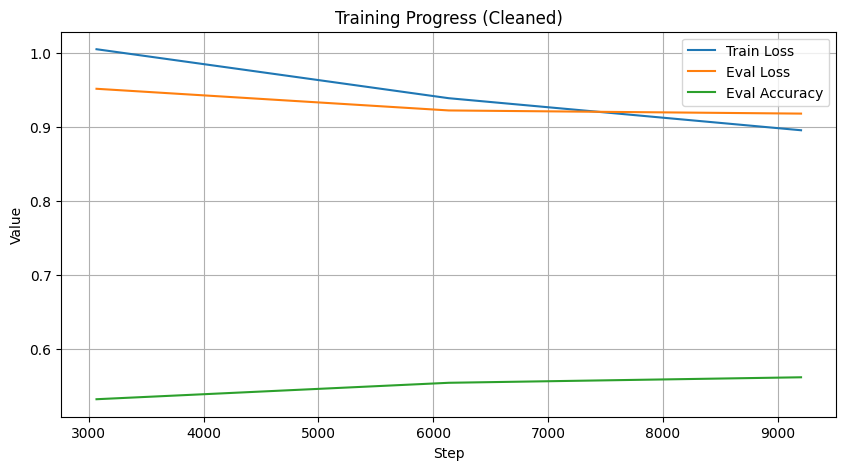

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)
x_axis = 'step' if 'step' in logs.columns else 'epoch'

plt.figure(figsize=(10, 5))

# Train Loss
if "loss" in logs.columns:
    plt.plot(
        logs.dropna(subset=["loss"]).drop_duplicates(subset=[x_axis])[x_axis],
        logs.dropna(subset=["loss"]).drop_duplicates(subset=[x_axis])["loss"],
        label="Train Loss"
    )

# Eval Loss
if "eval_loss" in logs.columns:
    plt.plot(
        logs.dropna(subset=["eval_loss"]).drop_duplicates(subset=[x_axis])[x_axis],
        logs.dropna(subset=["eval_loss"]).drop_duplicates(subset=[x_axis])["eval_loss"],
        label="Eval Loss"
    )

# Eval Accuracy
if "eval_accuracy" in logs.columns:
    plt.plot(
        logs.dropna(subset=["eval_accuracy"]).drop_duplicates(subset=[x_axis])[x_axis],
        logs.dropna(subset=["eval_accuracy"]).drop_duplicates(subset=[x_axis])["eval_accuracy"],
        label="Eval Accuracy"
    )

plt.xlabel(x_axis.capitalize())
plt.ylabel("Value")
plt.title("Training Progress (Cleaned)")
plt.legend()
plt.grid(True)
plt.show()

NaN 값이 많아 선이 끊김	-> dropna() 사용
동일한 step 값이 여러 번 등장 -> drop_duplicates() 사용

In [24]:
print(logs[["step", "loss", "eval_loss", "eval_accuracy"]].tail())

   step    loss  eval_loss  eval_accuracy
3  6136     NaN   0.921864       0.553846
4  9204  0.8951        NaN            NaN
5  9204     NaN   0.917597       0.561284
6  9204     NaN        NaN            NaN
7  9204     NaN   0.917597       0.561284


** 문장 쌍 직접 추론 예제 **

In [19]:
from transformers import pipeline

# 추론용 파이프라인 생성
inference = pipeline("text-classification", model=trainer.model, tokenizer=tokenizer)

# 문장 쌍 (MNLI 형식)
premise = "A man is playing the guitar."
hypothesis = "Someone is making music."

# 두 문장을 합쳐서 입력
text = premise + " " + hypothesis

# 추론 실행
result = inference(text)
print(result)

Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.6919611096382141}]


<Figure size 600x600 with 0 Axes>

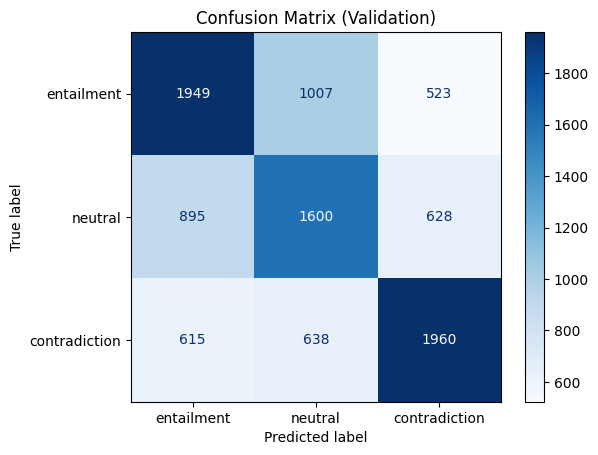

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 평가 데이터셋에서 예측
preds_output = trainer.predict(ds_tokenized["validation_matched"])
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=1)

# 라벨 이름
labels = ["entailment", "neutral", "contradiction"]

# 혼동 행렬 그리기
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Validation)")
plt.show()

In [28]:
from transformers import pipeline

# 추론 파이프라인 생성
inference_pipeline = pipeline("text-classification", model=trainer.model, tokenizer=tokenizer)

# 문장쌍 리스트 예제
examples = [
    ("A man is playing the guitar.", "Someone is making music."),  # entailment
    ("A woman is running.", "A person is sitting."),              # contradiction
    ("Kids are playing in a yard.", "Children might be outdoors."), # neutral
]

# 결과 출력
for premise, hypothesis in examples:
    text = premise + " " + hypothesis  # 단순 이어붙이기 방식 (tokenizer가 알아서 처리)
    result = inference_pipeline(text)[0]
    label_id = int(result["label"].split("_")[-1])  # 'LABEL_0' → 0
    score = result["score"]
    print(f"[예측] {label_id} ({labels[label_id]}) | 점수: {score:.4f}")
    print(f"Premise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print("-" * 50)

Device set to use cuda:0


[예측] 0 (entailment) | 점수: 0.6920
Premise: A man is playing the guitar.
Hypothesis: Someone is making music.
--------------------------------------------------
[예측] 0 (entailment) | 점수: 0.6003
Premise: A woman is running.
Hypothesis: A person is sitting.
--------------------------------------------------
[예측] 0 (entailment) | 점수: 0.6460
Premise: Kids are playing in a yard.
Hypothesis: Children might be outdoors.
--------------------------------------------------
